## DMW1 Lab 1: Customer Personality Analysis Dataset

## Import Libraries

In [35]:
import pandas as pd
# import matplotlib as plt
import seaborn as sns
import numpy as np
import sqlite3
from matplotlib.colors import ListedColormap
from matplotlib import colors
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

## Create Database

In [36]:
# data = pd.read_csv('/mnt/data/public/customer-personality-analysis/marketing_campaign.csv', sep='\t')
# print(data.info())
# print(f"DataFrame Shape: {data.shape}")
# data

In [37]:
# conn = sqlite3.connect('Lab1.db')
# data.to_sql('Customer_Personality_Analysis', conn, if_exists='replace', index=False)
# conn.commit()
# conn.close()

In [38]:
conn = sqlite3.connect('Lab1.db')
table = pd.read_sql('SELECT * FROM Customer_Personality_Analysis', conn) # Test to see if the table is in the database
table

ID  Year_Birth   Education Marital_Status   Income  Kidhome  \
0      5524        1957  Graduation         Single  58138.0        0   
1      2174        1954  Graduation         Single  46344.0        1   
2      4141        1965  Graduation       Together  71613.0        0   
3      6182        1984  Graduation       Together  26646.0        1   
4      5324        1981         PhD        Married  58293.0        1   
...     ...         ...         ...            ...      ...      ...   
2235  10870        1967  Graduation        Married  61223.0        0   
2236   4001        1946         PhD       Together  64014.0        2   
2237   7270        1981  Graduation       Divorced  56981.0        0   
2238   8235        1956      Master       Together  69245.0        0   
2239   9405        1954         PhD        Married  52869.0        1   

      Teenhome Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  \
0            0  04-09-2012       58       635  ...                  7   
1            1  08-03-2014       38        11  ...                  5   
2            0  21-08-2013       26       426  ...                  4   
3            0  10-02-2014       26        11  ...                  6   
4            0  19-01-2014       94       173  ...                  5   
...        ...         ...      ...       ...  ...                ...   
2235         1  13-06-2013       46       709  ...                  5   
2236         1  10-06-2014       56       406  ...                  7   
2237         0  25-01-2014       91       908  ...                  6   
2238         1  24-01-2014        8       428  ...                  3   
2239         1  15-10-2012       40        84  ...                  7   

      AcceptedCmp3  AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  \
0                0             0             0             0             0   
1                0             0             0             0             0   
2                0             0             0             0             0   
3                0             0             0             0             0   
4                0             0             0             0             0   
...            ...           ...           ...           ...           ...   
2235             0             0             0             0             0   
2236             0             0             0             1             0   
2237             0             1             0             0             0   
2238             0             0             0             0             0   
2239             0             0             0             0             0   

      Complain  Z_CostContact  Z_Revenue  Response  
0            0              3         11         1  
1            0              3         11         0  
2            0              3         11         0  
3            0              3         11         0  
4            0              3         11         0  
...        ...            ...        ...       ...  
2235         0              3         11         0  
2236         0              3         11         0  
2237         0              3         11         0  
2238         0              3         11         0  
2239         0              3         11         1  

[2240 rows x 29 columns]

In [39]:
conn.close()

## Exploratory Data Analysis

### Data Cleaning

In [40]:
df_main = table.dropna().copy()
print("Original Data Size:", len(table))
print("Missing Data points dropped:", len(df_main))

Original Data Size: 2240
Missing Data points dropped: 2216


Converting Customer Date into Number of days as a customer with reference to the oldest and the newest recorded customer

In [41]:
df_main["Dt_Customer"] = pd.to_datetime(df_main["Dt_Customer"], dayfirst=True)
dates = []
for i in df_main["Dt_Customer"]:
    i = i.date()
    dates.append(i)  
#Dates of the newest and oldest recorded customer
print("The newest customer's enrolment date in therecords:",max(dates))
print("The oldest customer's enrolment date in the records:",min(dates))
df_main["Dt_Customer"].head()

The newest customer's enrolment date in therecords: 2014-06-29
The oldest customer's enrolment date in the records: 2012-07-30


0   2012-09-04
1   2014-03-08
2   2013-08-21
3   2014-02-10
4   2014-01-19
Name: Dt_Customer, dtype: datetime64[ns]

In [42]:
newest = df_main["Dt_Customer"].max()
# number of days each customer has been active, measured relative to the newest record
df_main["Dt_Customer"] = (newest - df_main["Dt_Customer"]).dt.days
df_main.rename(columns={"Dt_Customer": "Days as Customer"}, inplace=True)
df_main["Days as Customer"].head()

0    663
1    113
2    312
3    139
4    161
Name: Days as Customer, dtype: int64

Other Changes to simplify dataset

In [43]:
# Converting Year of Birth to an Age Value
df_main["Year_Birth"] = (newest.year - table["Year_Birth"])
df_main.rename(columns={"Year_Birth": "Age"}, inplace=True)
# print(df_main["Age"].head())

# Combining Total Purchases
df_main["Spent"] = df_main["MntWines"]+ df_main["MntFruits"]+ df_main["MntMeatProducts"]+ df_main["MntFishProducts"]+ df_main["MntSweetProducts"]+ df_main["MntGoldProds"]
# print(df_main["Spent"].head())

# Combining Total Purchases with Weight on each product
df_main["Spent_Weighted"] = (df_main["MntWines"]*3+ 
                             df_main["MntFruits"]*1+ 
                             df_main["MntMeatProducts"]*5+ 
                             df_main["MntFishProducts"]*4+ 
                             df_main["MntSweetProducts"]*2+ 
                             df_main["MntGoldProds"]*6)
# print(df_main["Spent_Weighted"].head())

# Simplifying Marital Status Column
df_main["Marital_Status"]=table["Marital_Status"].replace({"Married":"Not Alone", "Together":"Not Alone", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Not Alone", "Divorced":"Alone", "Single":"Alone",})
df_main.rename(columns={"Marital_Status": "Relationship Status"}, inplace=True)

#
#Feature indicating total children living in the household
df_main["Children"]=table["Kidhome"]+table["Teenhome"]
df_main = df_main.drop(columns = ["Kidhome","Teenhome"])

#Feature for total members in the householde
status_weight = {"Alone": 1, "Not Alone": 2}
df_main["Family_Size"] = (
    df_main["Relationship Status"].map(status_weight).astype("Int64")
    + df_main["Children"]
)

#Dropping some of the redundant features
# to_drop = ["Z_CostContact", "Z_Revenue","Complain","Response"]
to_drop = ["Z_CostContact", "Z_Revenue","Complain"]
df_main = df_main.drop(to_drop, axis=1)

#Feature pertaining parenthood
df_main["Is_Parent"] = np.where(df_main.Children> 0, 1, 0)

In [44]:
# df_main["Education"]=table["Education"].replace({"Basic":1,"2n Cycle":3, "Graduation":2, "Master":4, "PhD":5})
df_main.head()

ID  Age   Education Relationship Status   Income  Days as Customer  \
0  5524   57  Graduation               Alone  58138.0               663   
1  2174   60  Graduation               Alone  46344.0               113   
2  4141   49  Graduation           Not Alone  71613.0               312   
3  6182   30  Graduation           Not Alone  26646.0               139   
4  5324   33         PhD           Not Alone  58293.0               161   

   Recency  MntWines  MntFruits  MntMeatProducts  ...  AcceptedCmp4  \
0       58       635         88              546  ...             0   
1       38        11          1                6  ...             0   
2       26       426         49              127  ...             0   
3       26        11          4               20  ...             0   
4       94       173         43              118  ...             0   

   AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Response  Spent  Spent_Weighted  \
0             0             0             0         1   1617            6115   
1             0             0             0         0     27             110   
2             0             0             0         0    776            2700   
3             0             0             0         0     53             213   
4             0             0             0         0    422            1480   

   Children  Family_Size  Is_Parent  
0         0            1          0  
1         2            3          1  
2         0            2          0  
3         1            3          1  
4         1            3          1  

[5 rows x 29 columns]

Removing Outliers

In [45]:
import pandas as pd

def remove_outliers_iqr(df, columns=None, multiplier=1.5):
    df_clean = df.copy()
    
    # If no columns specified, use all numeric columns
    if columns is None:
        columns = df_clean.select_dtypes(include=['float64', 'int64']).columns
    
    print(f"Applying outlier removal to: {list(columns)}")

    for col in columns:
        Q1 = df_clean[col].quantile(0.1)
        Q3 = df_clean[col].quantile(0.9)
        IQR = Q3 - Q1
        lower = Q1 - multiplier * IQR
        upper = Q3 + multiplier * IQR
        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]

    return df_clean

# Choose columns to clean (you can edit this list)
cols_to_clean = ["Income", "Spent", "MntWines","Age"]
df_cleaned = remove_outliers_iqr(df_main, columns=cols_to_clean)
print(f"Before: {df_main.shape}, After: {df_cleaned.shape}")
df_main = df_cleaned.copy()


Applying outlier removal to: ['Income', 'Spent', 'MntWines', 'Age']
Before: (2216, 29), After: (2212, 29)


Initial Data Describe

In [46]:
df_main.describe()

ID          Age         Income  Days as Customer  \
count   2212.000000  2212.000000    2212.000000       2212.000000   
mean    5585.160940    45.086347   51958.810579        353.714286   
std     3247.523735    11.701599   21527.278844        202.494886   
min        0.000000    18.000000    1730.000000          0.000000   
25%     2814.750000    37.000000   35233.500000        180.000000   
50%     5454.500000    44.000000   51371.000000        356.000000   
75%     8418.500000    55.000000   68487.000000        529.000000   
max    11191.000000    74.000000  162397.000000        699.000000   

           Recency     MntWines    MntFruits  MntMeatProducts  \
count  2212.000000  2212.000000  2212.000000      2212.000000   
mean     49.019439   305.287523    26.329566       167.029837   
std      28.943121   337.322940    39.744052       224.254493   
min       0.000000     0.000000     0.000000         0.000000   
25%      24.000000    24.000000     2.000000        16.000000   
50%      49.000000   175.500000     8.000000        68.000000   
75%      74.000000   505.000000    33.000000       232.250000   
max      99.000000  1493.000000   199.000000      1725.000000   

       MntFishProducts  MntSweetProducts  ...  AcceptedCmp4  AcceptedCmp5  \
count      2212.000000       2212.000000  ...   2212.000000   2212.000000   
mean         37.648734         27.046564  ...      0.074141      0.072785   
std          54.772033         41.090991  ...      0.262060      0.259842   
min           0.000000          0.000000  ...      0.000000      0.000000   
25%           3.000000          1.000000  ...      0.000000      0.000000   
50%          12.000000          8.000000  ...      0.000000      0.000000   
75%          50.000000         33.000000  ...      0.000000      0.000000   
max         259.000000        262.000000  ...      1.000000      1.000000   

       AcceptedCmp1  AcceptedCmp2     Response        Spent  Spent_Weighted  \
count   2212.000000   2212.000000  2212.000000  2212.000000     2212.000000   
mean       0.064195      0.013562     0.150542   607.268083     2245.584539   
std        0.245156      0.115691     0.357683   602.513364     2244.817779   
min        0.000000      0.000000     0.000000     5.000000       18.000000   
25%        0.000000      0.000000     0.000000    69.000000      273.000000   
50%        0.000000      0.000000     0.000000   397.000000     1438.500000   
75%        0.000000      0.000000     0.000000  1048.000000     3793.750000   
max        1.000000      1.000000     1.000000  2525.000000     9515.000000   

          Children  Family_Size    Is_Parent  
count  2212.000000       2212.0  2212.000000  
mean      0.947559     2.594033     0.714286  
std       0.749466     0.906143     0.451856  
min       0.000000          1.0     0.000000  
25%       0.000000          2.0     0.000000  
50%       1.000000          3.0     1.000000  
75%       1.000000          3.0     1.000000  
max       3.000000          5.0     1.000000  

[8 rows x 27 columns]

### Statistical Analysis
- pvalue comparisons
- what groups are significantly different

Confusion Heatmap Analysis
- Strong Positive Correlation on Amount Spent(Both Amount and Weighted) to Income
- Strong Positive Correlation of Income to No. Store Purchases
- Strong Negative Correlation of Income to No. of Web Visits

<Axes: >

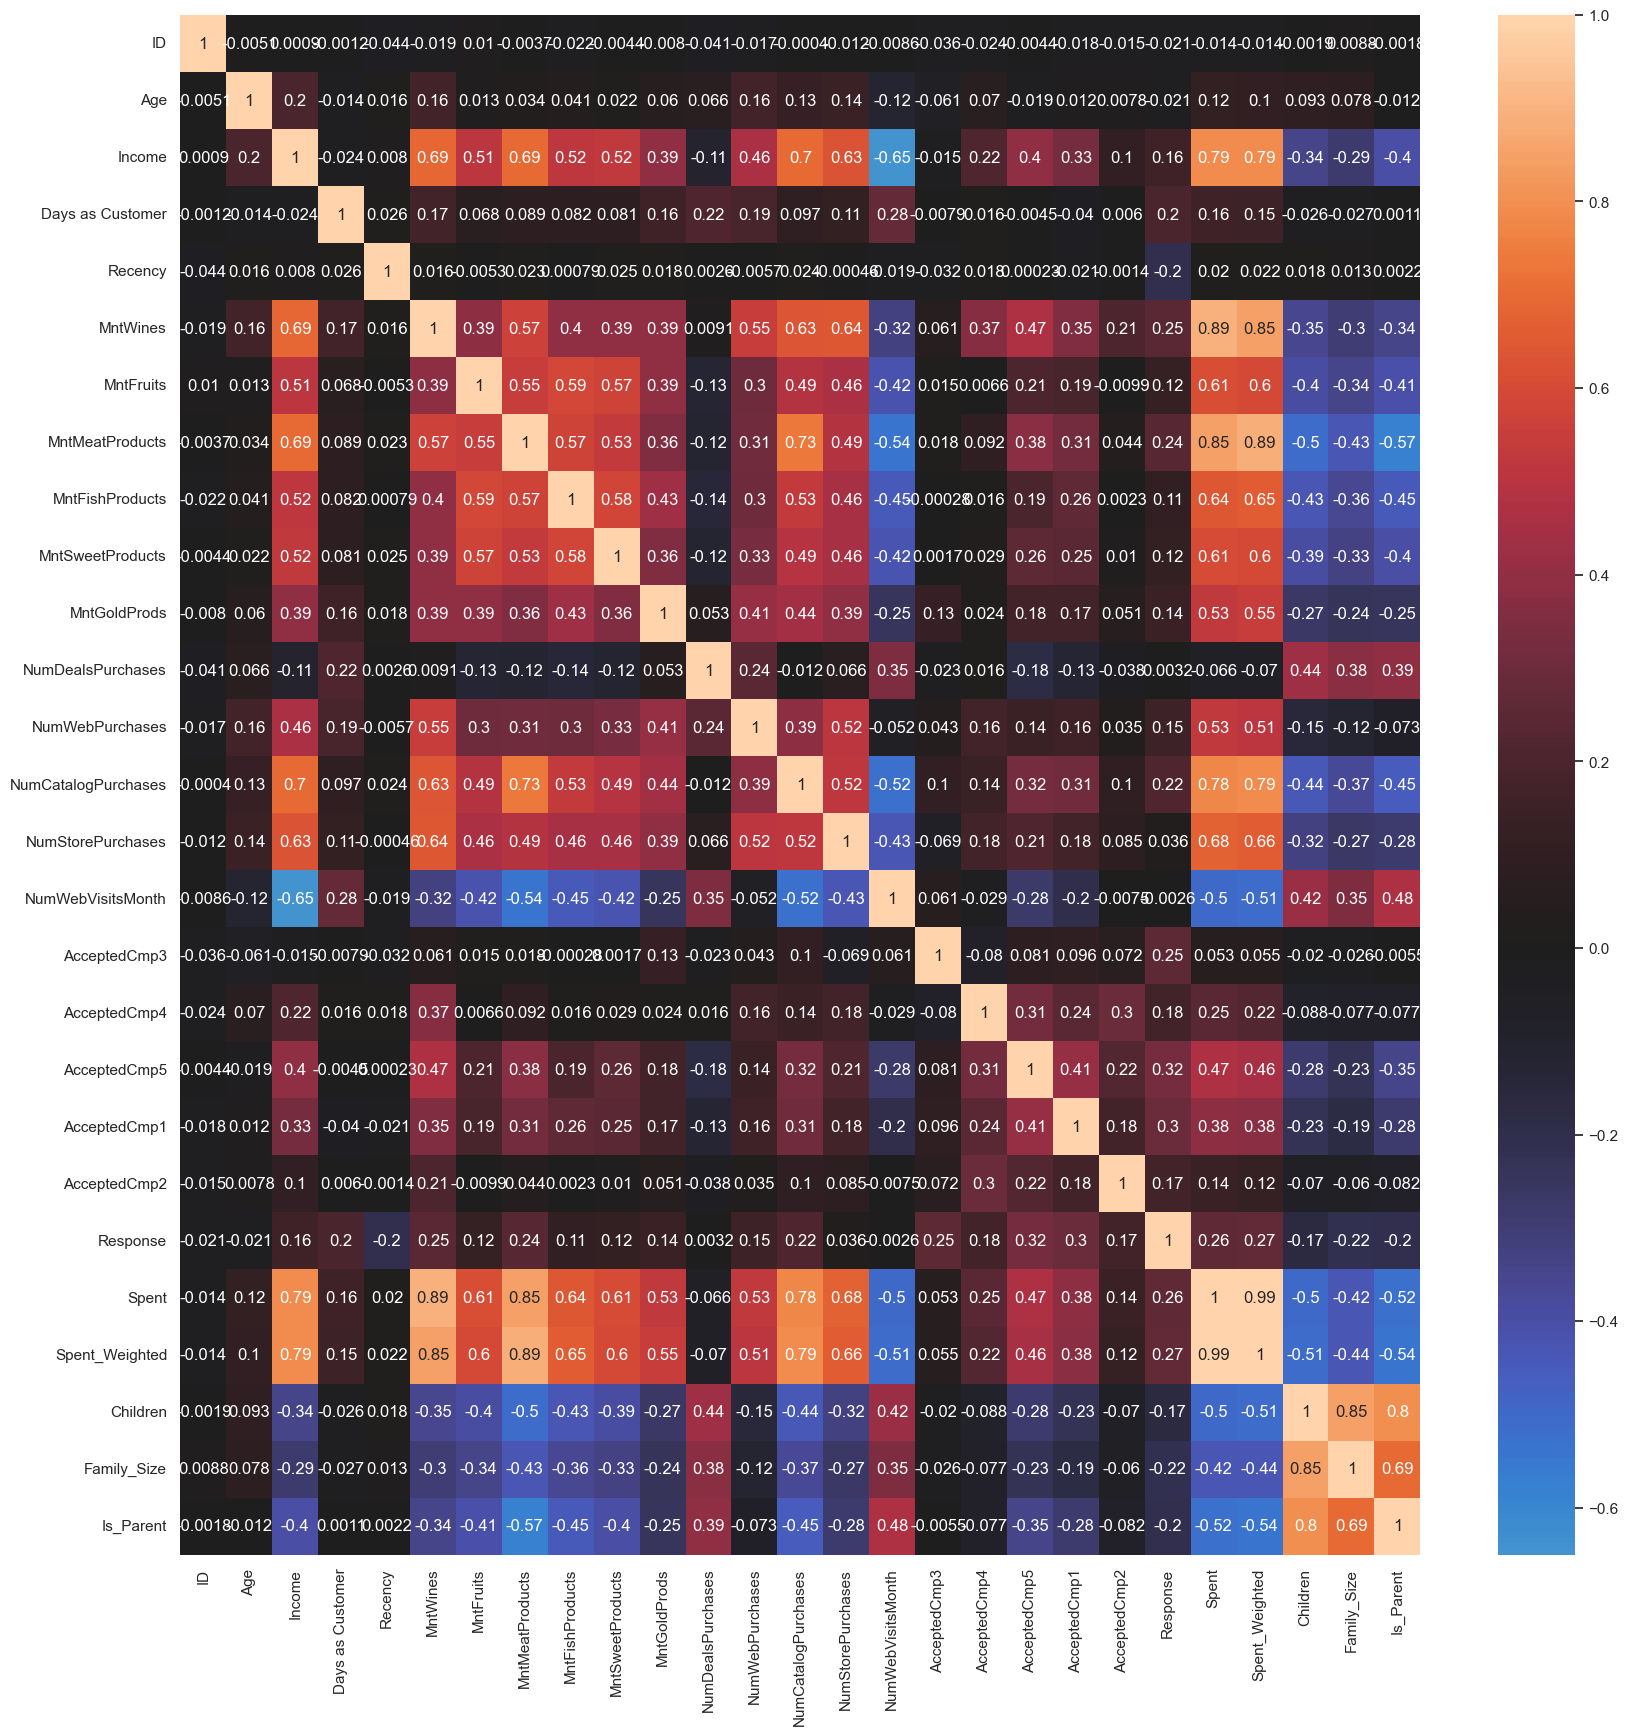

In [47]:
# Color  Setup
# cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])
#correlation matrix
corrmat= df_main.corr(numeric_only=True)
plt.figure(figsize=(20,20))  
sns.heatmap(corrmat,annot=True, center=0)

Correlation Table
Correlation Observation
- slight positive correlation of number of kids to income
- Strong Positive Correlation for amount of Wine Purchased with Amount Spent
- Strong Negative Correlation with Number of Website Visits with Individuals Income
- positive correlation observed in the number of store purchases with income
- negative correlation observed in the number of website visits with income



In [62]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
# import numpy as np
# import pandas as pd

# Standardized data for r2 and slope
scaler = StandardScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df_main.select_dtypes(include=["float64", "int64"])),
    columns=df_main.select_dtypes(include=["float64", "int64"]).columns
)

# Absolute data for correlation data
corr_pairs = (
    corrmat.unstack()
    .reset_index()
    .rename(columns={'level_0': 'Variable 1', 'level_1': 'Variable 2', 0: 'Correlation'})
)

# Remove self-correlations
corr_pairs = corr_pairs[corr_pairs["Variable 1"] != corr_pairs["Variable 2"]]

# Remove duplicate pairs
corr_pairs["pair"] = corr_pairs.apply(lambda x: "-".join(sorted([x["Variable 1"], x["Variable 2"]])), axis=1)
corr_pairs = corr_pairs.drop_duplicates(subset="pair").drop(columns="pair")

# Filter by minimum correlation if needed
corr_pairs = corr_pairs[abs(corr_pairs["Correlation"]) > 0.2].copy()

# --- Add slope and R² for each pair ---
slopes = []
r2_scores = []

for _, row in corr_pairs.iterrows():
    x = df_main[[row["Variable 1"]]].values
    y = df_main[row["Variable 2"]].values
    
    # Drop NaNs to avoid regression errors
    mask = ~np.isnan(x.flatten()) & ~np.isnan(y)
    x_clean = x[mask].reshape(-1, 1)
    y_clean = y[mask]
    
    if len(x_clean) > 1:
        model = LinearRegression()
        model.fit(x_clean, y_clean)
        slope = model.coef_[0]
        r2 = model.score(x_clean, y_clean)
    else:
        slope, r2 = np.nan, np.nan  # handle edge cases with few valid points
    
    slopes.append(slope)
    r2_scores.append(r2)

corr_pairs["Slope"] = slopes
corr_pairs["R²"] = r2_scores

# Sort for convenience

corr_pairs["Abs_Correlation"] = np.abs(corr_pairs["Correlation"])
corr_pairs = corr_pairs.sort_values(by="Abs_Correlation", ascending=False).reset_index(drop=True)
corr_pairs.head(10)


Variable 1      Variable 2  Correlation       Slope        R²  \
0                Spent  Spent_Weighted     0.993448    3.701346  0.986940   
1             MntWines           Spent     0.892996    1.595036  0.797442   
2      MntMeatProducts  Spent_Weighted     0.890176    8.910777  0.792412   
3             Children     Family_Size     0.849732    1.027370  0.722044   
4             MntWines  Spent_Weighted     0.848488    5.646520  0.719932   
5      MntMeatProducts           Spent     0.845543    2.271753  0.714943   
6             Children       Is_Parent     0.799802    0.482204  0.639683   
7               Income           Spent     0.792740    0.022187  0.628436   
8  NumCatalogPurchases  Spent_Weighted     0.792127  607.397203  0.627465   
9               Income  Spent_Weighted     0.788605    0.082234  0.621898   

   Abs_Correlation  
0         0.993448  
1         0.892996  
2         0.890176  
3         0.849732  
4         0.848488  
5         0.845543  
6         0.799802  
7         0.792740  
8         0.792127  
9         0.788605

In [49]:
df_main.columns

Index(['ID', 'Age', 'Education', 'Relationship Status', 'Income',
       'Days as Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Response', 'Spent', 'Spent_Weighted', 'Children',
       'Family_Size', 'Is_Parent'],
      dtype='object')

Pairplot Analysis. Customer Demographic
Cluster/Histogram Observation
- Parents have a higher chance to have more Website Visits than Non Parents
- Parents have a higher chance to have less income than Non Parents
- Parents generally spend less than Non parents
- suggests parents may spend less than people who arent parents
- suggests more people who are not parents have higher income
- suggests parents spend more on wine and less on meat than people who arent parents. May be wise to look into ratios of Grocery Item to Amount Spent

Relative Plot Of Some Selected Features: A Data Subset


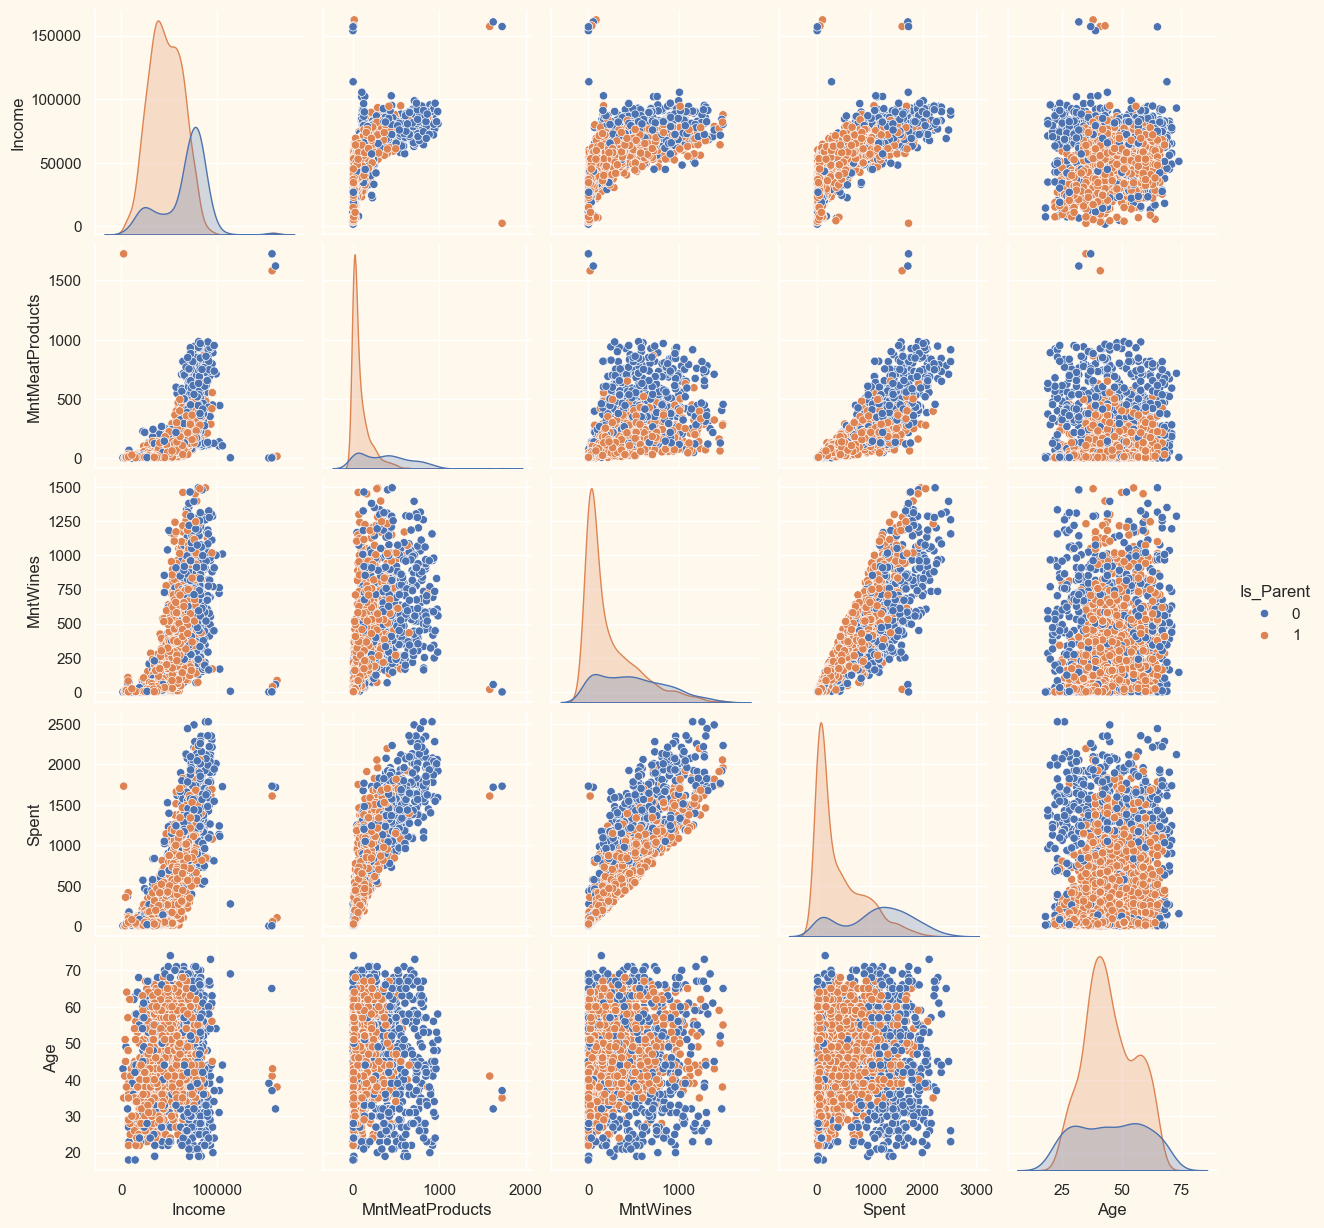

In [50]:

# Set custom background
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})

# Define palette and colormap
# palette = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
# cmap = colors.ListedColormap(palette)

# Features to plot
To_Plot = ["Income", "MntMeatProducts","MntWines", "Spent", "Age"]
To_Plot = ["Income", "MntMeatProducts","MntWines", "Spent", "Age" ]

print("Relative Plot Of Some Selected Features: A Data Subset")

# Plot
sns.pairplot(
    data=df_main,
    vars=To_Plot,
    # hue="Education",
    # hue="Relationship Status"
    hue="Is_Parent"
    # diag_kind="kde"   # optional: smooth density on diagonals
)

plt.show()


In [51]:
df_main

ID  Age   Education Relationship Status   Income  Days as Customer  \
0      5524   57  Graduation               Alone  58138.0               663   
1      2174   60  Graduation               Alone  46344.0               113   
2      4141   49  Graduation           Not Alone  71613.0               312   
3      6182   30  Graduation           Not Alone  26646.0               139   
4      5324   33         PhD           Not Alone  58293.0               161   
...     ...  ...         ...                 ...      ...               ...   
2235  10870   47  Graduation           Not Alone  61223.0               381   
2236   4001   68         PhD           Not Alone  64014.0                19   
2237   7270   33  Graduation               Alone  56981.0               155   
2238   8235   58      Master           Not Alone  69245.0               156   
2239   9405   60         PhD           Not Alone  52869.0               622   

      Recency  MntWines  MntFruits  MntMeatProducts  ...  AcceptedCmp4  \
0          58       635         88              546  ...             0   
1          38        11          1                6  ...             0   
2          26       426         49              127  ...             0   
3          26        11          4               20  ...             0   
4          94       173         43              118  ...             0   
...       ...       ...        ...              ...  ...           ...   
2235       46       709         43              182  ...             0   
2236       56       406          0               30  ...             0   
2237       91       908         48              217  ...             1   
2238        8       428         30              214  ...             0   
2239       40        84          3               61  ...             0   

      AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Response  Spent  \
0                0             0             0         1   1617   
1                0             0             0         0     27   
2                0             0             0         0    776   
3                0             0             0         0     53   
4                0             0             0         0    422   
...            ...           ...           ...       ...    ...   
2235             0             0             0         0   1341   
2236             0             1             0         0    444   
2237             0             0             0         0   1241   
2238             0             0             0         0    843   
2239             0             0             0         1    172   

      Spent_Weighted  Children  Family_Size  Is_Parent  
0               6115         0            1          0  
1                110         2            3          1  
2               2700         0            2          0  
3                213         1            3          1  
4               1480         1            3          1  
...              ...       ...          ...        ...  
2235            4966         1            3          1  
2236            1416         3            5          1  
2237            4153         0            1          0  
2238            3130         1            3          1  
2239             696         2            4          1  

[2212 rows x 29 columns]

Pairplot Analysis. Purchase Behavior
- Parents seem to have more interest in Purchase Deals than Non Parents
- Parents have higher Website Visits than non parents


Relative Plot Of Some Selected Features: A Data Subset


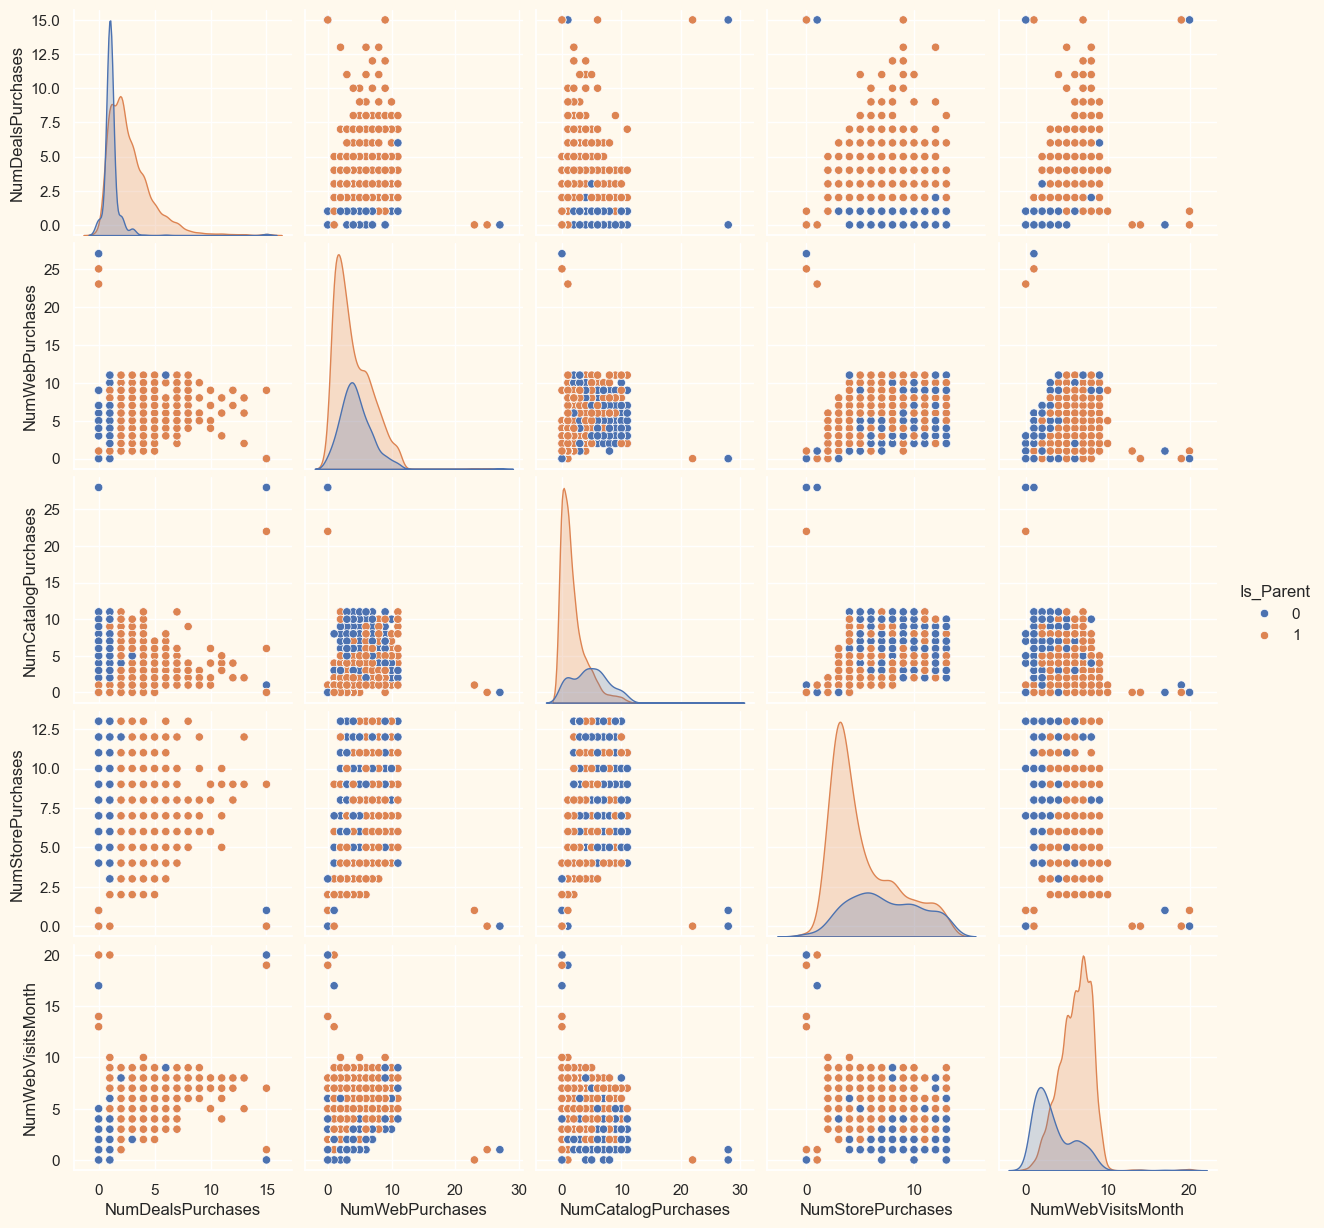

In [52]:

# Set custom background
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})

# Define palette and colormap
# palette = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
# cmap = colors.ListedColormap(palette)

# Features to plot
To_Plot = ['NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', ]

print("Relative Plot Of Some Selected Features: A Data Subset")

# Plot
sns.pairplot(
    data=df_main,
    vars=To_Plot,
    # hue="Education",
    # hue="Relationship Status"
    hue="Is_Parent"
    # diag_kind="kde"   # optional: smooth density on diagonals
)

plt.show()


Histogram Analysis
- Outliers removed for age and income based on observation from histogram data

In [53]:
df_main.columns

Index(['ID', 'Age', 'Education', 'Relationship Status', 'Income',
       'Days as Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Response', 'Spent', 'Spent_Weighted', 'Children',
       'Family_Size', 'Is_Parent'],
      dtype='object')

In [54]:
def plot_hist_subplots(df, columns=None, n_cols=3, nbins=30,v_space=0.05, color="#9E726F"):
    """
    Create Plotly histogram subplots for selected columns.

    Parameters:
        df (pd.DataFrame): Data source
        columns (list): Columns to plot. If None, all numeric columns are used.
        n_cols (int): Number of subplots per row
        nbins (int): Number of bins for each histogram
        color (str): Histogram color (hex)
    """
    # Auto-select numeric columns if none are specified
    if columns is None:
        columns = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

    # Handle case where list is empty
    if len(columns) == 0:
        raise ValueError("No numeric columns to plot.")

    # Grid layout
    n_rows = (len(columns) + n_cols - 1) // n_cols
    fig = make_subplots(
        rows=n_rows, cols=n_cols,
        subplot_titles=columns,
        horizontal_spacing=0.08,
        vertical_spacing=v_space,
    )

    # Add histograms
    for i, col in enumerate(columns):
        row = i // n_cols + 1
        col_pos = i % n_cols + 1
        fig.add_trace(
            go.Histogram(
                x=df[col],
                nbinsx=nbins,
                marker_color=color,
                opacity=0.8,
                name=col
            ),
            row=row, col=col_pos
        )

    # Layout
    fig.update_layout(
        height=n_rows * 200,
        # width=1000,
        showlegend=False,
        title_text="Distribution of Selected Features",
        template="plotly_white"
    )

    fig.show()

# Select specific columns to visualize
plot_hist_subplots(df_main, columns=['ID', 'Age', 'Education', 
        'Relationship Status', 'Income',
        'Days as Customer', 'Recency', 'MntWines', 'MntFruits',
        'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
        'MntGoldProds', 'Spent', 'Spent_Weighted',
        ], n_cols=2, nbins=9,color="#F3AB60")


In [55]:


plot_hist_subplots(df_main, columns=[
        'NumDealsPurchases', 'NumWebPurchases',
        'NumCatalogPurchases','NumWebVisitsMonth',
        ], n_cols=2, nbins=15,v_space=0.2,color="#F3AB60")

In [56]:
plot_hist_subplots(df_main, columns=[
        'Children', 'Family_Size', 'Is_Parent','NumStorePurchases',
        ], n_cols=2, nbins=5,v_space=0.2,color="#F3AB60")

Normality Test
- All data are non normal proceed with Kruskal-Wallis instead of ANOVA analysis

In [63]:
import pandas as pd
from scipy.stats import shapiro

# Create a results list
results = []

# Loop through each numeric column
for col in df_main.select_dtypes(include=['float64', 'int64']).columns:
    # Drop NaN values
    data = df_main[col].dropna()
    if len(data) > 2:  # Shapiro requires at least 3 samples
        stat, p_value = shapiro(data)
        results.append({
            'Feature': col,
            'Statistic': stat,
            'p-value': p_value,
            'Normal?': 'Yes' if p_value > 0.05 else 'No'
        })
    else:
        results.append({
            'Feature': col,
            'Statistic': None,
            'p-value': None,
            'Normal?': 'Not enough data'
        })

# Convert results to a DataFrame
shapiro_results = pd.DataFrame(results)

# Display neatly
print(shapiro_results.head(10))


            Feature  Statistic       p-value Normal?
0                ID   0.954126  8.387606e-26      No
1               Age   0.983262  1.874685e-15      No
2            Income   0.975152  3.597610e-19      No
3  Days as Customer   0.954006  7.817008e-26      No
4           Recency   0.954251  9.024079e-26      No
5          MntWines   0.839019  1.122072e-42      No
6         MntFruits   0.689786  2.941028e-53      No
7   MntMeatProducts   0.733758  1.103049e-50      No
8   MntFishProducts   0.708824  3.491671e-52      No
9  MntSweetProducts   0.688317  2.442858e-53      No


Recency. Frequency. Monetary Analysis

### Statistical Analysis: Customer Behavior Data

Boxplot Analysis
- Education Background
    - Basic has just graduated highschool. No Degree
    - Graduation. Has at least a Bachelor's Degree
    - 2n Cycle. In the process of Studying to get a Masters
- Observations
    - PhD Highest median income. Graduation people at 2nd. Basic education a the lowest income distribution
    - Older people are observed to have a higher income distribution than younger people. Maybe a T-test to find what age is most significant different.

In [23]:
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

df_sub = df_main.copy()

# Optional: define default order for consistency
edu_order = ["Basic", "Graduation", "Master", "2n Cycle", "PhD"]
df_sub["Education"] = pd.Categorical(df_sub["Education"], categories=edu_order, ordered=True)

# ---- 1. Compute median order based on Income ----
median_income = df_sub.groupby("Education")["Income"].median().sort_values()
sorted_edu_order = median_income.index.tolist()
print("Education sorted by increasing median income:", sorted_edu_order)

# ---- 2. Create subplot figure ----
fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.07,
    subplot_titles=("Age distribution by education level", "Income distribution by education level")
)

# ---- 3. AGE boxplot ----
fig_age = px.box(
    df_sub,
    x="Education",
    y="Age",
    category_orders={"Education": sorted_edu_order}
)

# ---- 4. INCOME boxplot ----
fig_income = px.box(
    df_sub,
    x="Education",
    y="Income",
    category_orders={"Education": sorted_edu_order}
)

# ---- 5. Add both traces to subplot ----
for trace in fig_age.data:
    fig.add_trace(trace, row=1, col=1)

for trace in fig_income.data:
    fig.add_trace(trace, row=2, col=1)

# ---- 6. Update layout ----
fig.update_layout(
    height=800,
    showlegend=False,
    title_text="Age and Income Distribution by Education Level (Sorted by Median Income)",
)

# ---- 7. Set axis titles and ranges ----
fig.update_yaxes(title_text="Age", row=1, col=1, range=[10, 80])
fig.update_yaxes(title_text="Income", row=2, col=1, range=[0, 120000])
fig.update_xaxes(title_text="Education level", row=2, col=1)

# ---- 8. Enforce sorted education order ----
fig.update_xaxes(categoryorder="array", categoryarray=sorted_edu_order)

fig.show()


Education sorted by increasing median income: ['Basic', '2n Cycle', 'Master', 'Graduation', 'PhD']


C:\Users\Enzo\AppData\Local\Temp\ipykernel_35184\3261920106.py:13: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [24]:
import pandas as pd
import plotly.express as px

# # Copy original dataframe
# df_sub = df_main.copy()

# Define 5-year bins (adjust max age to fit your dataset)
bins = range(0, df_sub["Age"].max() + 5, 5)
labels = [f"{i}-{i+4}" for i in bins[:-1]]

# Create a new column for age group
df_sub["AgeGroup"] = pd.cut(df_sub["Age"], bins=bins, labels=labels, right=False)

# Ensure correct categorical order (ascending age)
df_sub["AgeGroup"] = pd.Categorical(df_sub["AgeGroup"], categories=labels, ordered=True)

# Calculate frequency per age group
age_counts = df_sub["AgeGroup"].value_counts().sort_index()



# Update labels to include frequency (e.g. '20–24 (n=42)')
age_labels = [f"{grp} (n={age_counts.get(grp, 0)})" for grp in labels]

# Create mapping from original label to label-with-count
label_map = dict(zip(labels, age_labels))
df_sub["AgeGroupLabel"] = df_sub["AgeGroup"].map(label_map)

# Create boxplot
fig = px.box(
    df_sub,
    x="AgeGroupLabel",
    y="Income",
    labels={"AgeGroupLabel": "Age group (5-year bins)", "Income": "Income"},
    title="Income distribution by 5-year age group",
)

# Force correct order on x-axis
fig.update_xaxes(categoryorder="array", categoryarray=age_labels)
fig.update_layout(yaxis_range=[0, 120000])  # show bins 3rd to 9th initially
fig.update_xaxes(range=[2, 15])
fig.show()



# Optionally show frequencies
print("Frequency per age group:")
print(age_counts)

Frequency per age group:
AgeGroup
0-4        0
5-9        0
10-14      0
15-19      7
20-24     54
25-29    158
30-34    200
35-39    352
40-44    380
45-49    289
50-54    213
55-59    246
60-64    207
65-69     91
70-74     15
Name: count, dtype: int64


### Statistical Analysis: Grocery Item Data

Observations
- Wines are the most sold item next to meat sold at half the amount
- Fruits are sold the least amount of times

In [25]:
df_campaign = df_main.loc[:,['MntWines', 'MntFruits', 'MntMeatProducts', 
                             'MntFishProducts','MntSweetProducts','MntGoldProds']]
df_campaign.sum().sort_values(ascending=False)

MntWines            675296
MntMeatProducts     369470
MntGoldProds         97164
MntFishProducts      83279
MntSweetProducts     59827
MntFruits            58241
dtype: int64

In [82]:
df_main

ID  Age   Education Relationship Status   Income  Days as Customer  \
0      5524   57  Graduation               Alone  58138.0               663   
1      2174   60  Graduation               Alone  46344.0               113   
2      4141   49  Graduation           Not Alone  71613.0               312   
3      6182   30  Graduation           Not Alone  26646.0               139   
4      5324   33         PhD           Not Alone  58293.0               161   
...     ...  ...         ...                 ...      ...               ...   
2235  10870   47  Graduation           Not Alone  61223.0               381   
2236   4001   68         PhD           Not Alone  64014.0                19   
2237   7270   33  Graduation               Alone  56981.0               155   
2238   8235   58      Master           Not Alone  69245.0               156   
2239   9405   60         PhD           Not Alone  52869.0               622   

      Recency  MntWines  MntFruits  MntMeatProducts  ...  AcceptedCmp4  \
0          58       635         88              546  ...             0   
1          38        11          1                6  ...             0   
2          26       426         49              127  ...             0   
3          26        11          4               20  ...             0   
4          94       173         43              118  ...             0   
...       ...       ...        ...              ...  ...           ...   
2235       46       709         43              182  ...             0   
2236       56       406          0               30  ...             0   
2237       91       908         48              217  ...             1   
2238        8       428         30              214  ...             0   
2239       40        84          3               61  ...             0   

      AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Response  Spent  \
0                0             0             0         1   1617   
1                0             0             0         0     27   
2                0             0             0         0    776   
3                0             0             0         0     53   
4                0             0             0         0    422   
...            ...           ...           ...       ...    ...   
2235             0             0             0         0   1341   
2236             0             1             0         0    444   
2237             0             0             0         0   1241   
2238             0             0             0         0    843   
2239             0             0             0         1    172   

      Spent_Weighted  Children  Family_Size  Is_Parent  
0               6115         0            1          0  
1                110         2            3          1  
2               2700         0            2          0  
3                213         1            3          1  
4               1480         1            3          1  
...              ...       ...          ...        ...  
2235            4966         1            3          1  
2236            1416         3            5          1  
2237            4153         0            1          0  
2238            3130         1            3          1  
2239             696         2            4          1  

[2212 rows x 29 columns]

Grocery Item Ratio Observation

### Statistical Analysis: Campaign Data
Observations
- Based on Frequency Count Campaign 4,3 and 5 attracted a lot of people with Last Campaign or Campaign 6 attracting the most amount. Campaign 2 attracted significantly less people
- Individuals not affected by any campaign were not included in this analysis
- Add Response

In [26]:
df_main.columns

Index(['ID', 'Age', 'Education', 'Relationship Status', 'Income',
       'Days as Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Response', 'Spent', 'Spent_Weighted', 'Children',
       'Family_Size', 'Is_Parent'],
      dtype='object')

In [69]:
# Create labeled subsets for each campaign
df_campaign0 = df_main[
    (df_main['AcceptedCmp1'] == 0) &
    (df_main['AcceptedCmp2'] == 0) &
    (df_main['AcceptedCmp3'] == 0) &
    (df_main['AcceptedCmp4'] == 0) &
    (df_main['AcceptedCmp5'] == 0) &
    (df_main['Response'] == 0)
].copy()
df_campaign0["Campaign"] = "No Campaign"

df_campaign1 = df_main[df_main['AcceptedCmp1'] == 1].copy()
df_campaign1["Campaign"] = "Campaign 1"

df_campaign2 = df_main[df_main['AcceptedCmp2'] == 1].copy()
df_campaign2["Campaign"] = "Campaign 2"

df_campaign3 = df_main[df_main['AcceptedCmp3'] == 1].copy()
df_campaign3["Campaign"] = "Campaign 3"

df_campaign4 = df_main[df_main['AcceptedCmp4'] == 1].copy()
df_campaign4["Campaign"] = "Campaign 4"

df_campaign5 = df_main[df_main['AcceptedCmp5'] == 1].copy()
df_campaign5["Campaign"] = "Campaign 5"

df_campaign6 = df_main[df_main['Response'] == 1].copy()
df_campaign6["Campaign"] = "Campaign 6"

# Combine them into one DataFrame
df_campaign_all = pd.concat([
    # df_campaign0,
    # df_campaign6,
    df_campaign1,
    df_campaign2,
    df_campaign3,
    df_campaign4,
    df_campaign5,
    
], ignore_index=True)

# Check shape and distribution
print('No. of IDs purchased under each Campaign \n', df_campaign_all["Campaign"].value_counts())
print(df_campaign_all.shape)


No. of IDs purchased under each Campaign 
 Campaign
Campaign 4    164
Campaign 3    163
Campaign 5    161
Campaign 1    142
Campaign 2     30
Name: count, dtype: int64
(660, 30)


One-way ANOVA for each feature
- Overall Difference Across all Features
- Each tests whether at least one campaign group differs in the combined set of outcomes.
- Small p-values (< 0.05) mean: some features differ significantly among campaigns.

In [70]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.multivariate.manova import MANOVA


df_campaign_all["Campaign"] = df_campaign_all["Campaign"].astype("category")

features = ['Age', 'Income',
       'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'Spent', 'Spent_Weighted', 'Children', 'Family_Size',
       ]
formula = " + ".join(features) + " ~ Campaign"

# ------------------------
# Run one-way ANOVAs for each feature
# ------------------------
anova_results = []

for feature in features:
    model = ols(f"{feature} ~ C(Campaign)", data=df_campaign_all).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)

    # Extract values
    ss_effect = anova_table.loc["C(Campaign)", "sum_sq"]
    ss_resid  = anova_table.loc["Residual", "sum_sq"]
    df_effect = anova_table.loc["C(Campaign)", "df"]
    df_resid  = anova_table.loc["Residual", "df"]

    # Effect size metrics
    eta_sq = ss_effect / (ss_effect + ss_resid)
    omega_sq = (ss_effect - (df_effect * (ss_resid / df_resid))) / ((ss_effect + ss_resid) + (ss_resid / df_resid))

    anova_results.append({
        "Feature": feature,
        "F-statistic": anova_table.loc["C(Campaign)", "F"],
        "p-value": anova_table.loc["C(Campaign)", "PR(>F)"],
        # "Eta-squared": eta_sq, 
        # "Omega-squared": omega_sq
    })

# ------------------------
# Sort by effect size
# ------------------------
anova_df = pd.DataFrame(anova_results).sort_values("F-statistic", ascending=False).reset_index(drop=True)

print("\n=== Feature Differences Across Campaigns ===")
print(anova_df.head(10))


=== Feature Differences Across Campaigns ===
               Feature  F-statistic       p-value
0               Income   101.170884  4.725348e-67
1                Spent    59.819067  4.566773e-43
2       Spent_Weighted    57.772614  9.047564e-42
3    NumWebVisitsMonth    46.550825  1.906367e-34
4             MntWines    43.832483  1.289660e-32
5      MntMeatProducts    39.091257  2.278526e-29
6    NumStorePurchases    35.417805  8.369866e-27
7             Children    34.963226  1.750565e-26
8  NumCatalogPurchases    25.513989  1.146201e-19
9      MntFishProducts    23.233659  5.607260e-18


In [78]:
import pandas as pd
import numpy as np
from scipy.stats import kruskal
from statsmodels.stats.multitest import multipletests

# Ensure Campaign is categorical
df_campaign_all["Campaign"] = df_campaign_all["Campaign"].astype("category")
groups = df_campaign_all["Campaign"].cat.categories

features = [
    'Age', 'Income', 'Recency', 'MntWines', 'MntFruits',
    'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
    'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
    'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
    'Spent', 'Spent_Weighted', 'Children', 'Family_Size',
]

kw_results = []

for feature in features:
    # Collect non-missing values per Campaign group
    data_by_group = [df_campaign_all.loc[df_campaign_all["Campaign"] == g, feature].dropna().values
                     for g in groups]
    # Remove groups with <1 observation (Kruskal requires ≥1 per group and ≥2 groups total)
    data_by_group = [arr for arr in data_by_group if len(arr) > 0]

    if len(data_by_group) < 2:
        kw_results.append({
            "Feature": feature,
            "H-statistic": np.nan,
            "p-value": np.nan,
            "epsilon^2": np.nan,   # effect size
            "N": sum(len(a) for a in data_by_group),
            "k": len(data_by_group),
            "Note": "Insufficient groups with data"
        })
        continue

    # Run Kruskal–Wallis
    H, p = kruskal(*data_by_group)

    # Effect size for Kruskal–Wallis (Tomczak & Tomczak, 2014):
    # epsilon^2 = (H - k + 1) / (N - k)
    N = sum(len(a) for a in data_by_group)
    k = len(data_by_group)
    eps2 = np.nan
    if (N - k) > 0:
        eps2 = (H - k + 1) / (N - k)

    kw_results.append({
        "Feature": feature,
        "H-statistic": H,
        "p-value": p,
        "epsilon^2": eps2,
        "N": N,
        "k": k,
        "Note": ""
    })

kw_df = pd.DataFrame(kw_results)

# Multiple-testing correction across features (FDR, Benjamini–Hochberg)
mask = kw_df["p-value"].notna()
rej, p_adj, _, _ = multipletests(kw_df.loc[mask, "p-value"], method="fdr_bh")
kw_df.loc[mask, "p-adj (BH)"] = p_adj
kw_df.loc[mask, "Significant (BH, q=0.05)"] = rej

# Sort for display (by H-statistic descending)
kw_df = kw_df.sort_values("H-statistic", ascending=False).reset_index(drop=True)

print("\n=== Kruskal–Wallis (Nonparametric) Differences Across Campaigns ===")
# print(kw_df.loc[:, ["Feature", "H-statistic", "p-value", "p-adj (BH)", "Significant (BH, q=0.05)", "epsilon^2"]].head(10))
# print(kw_df.loc[:, ["Feature", "H-statistic", "p-value", "p-adj (BH)"]].head(10))
kw_df.head(10)



=== Kruskal–Wallis (Nonparametric) Differences Across Campaigns ===


Feature  H-statistic       p-value  epsilon^2    N  k Note  \
0             Income   209.633732  3.185432e-44   0.313945  660  5        
1     Spent_Weighted   162.028719  5.367854e-34   0.241265  660  5        
2    MntMeatProducts   158.292225  3.397524e-33   0.235561  660  5        
3              Spent   157.852524  4.221330e-33   0.234889  660  5        
4  NumWebVisitsMonth   145.371067  1.997359e-30   0.215834  660  5        
5           Children   137.536968  9.503556e-29   0.203873  660  5        
6           MntWines   134.321764  4.633772e-28   0.198965  660  5        
7  NumStorePurchases   112.075841  2.625451e-23   0.165001  660  5        
8   MntSweetProducts   111.570936  3.364468e-23   0.164230  660  5        
9  NumDealsPurchases    98.732856  1.830518e-20   0.144630  660  5        

     p-adj (BH) Significant (BH, q=0.05)  
0  5.733778e-43                     True  
1  4.831069e-33                     True  
2  1.899599e-32                     True  
3  1.899599e-32                     True  
4  7.190493e-30                     True  
5  2.851067e-28                     True  
6  1.191541e-27                     True  
7  5.907266e-23                     True  
8  6.728935e-23                     True  
9  3.294932e-20                     True

These ten features have been strongly affected by the different campaigns

Pairplot Analysis
- Plotting Top 5 and Top 10 features with the highest variation across features for each campaign
- Initial Analysis to observe any unique group behaviors between marketing campaigns

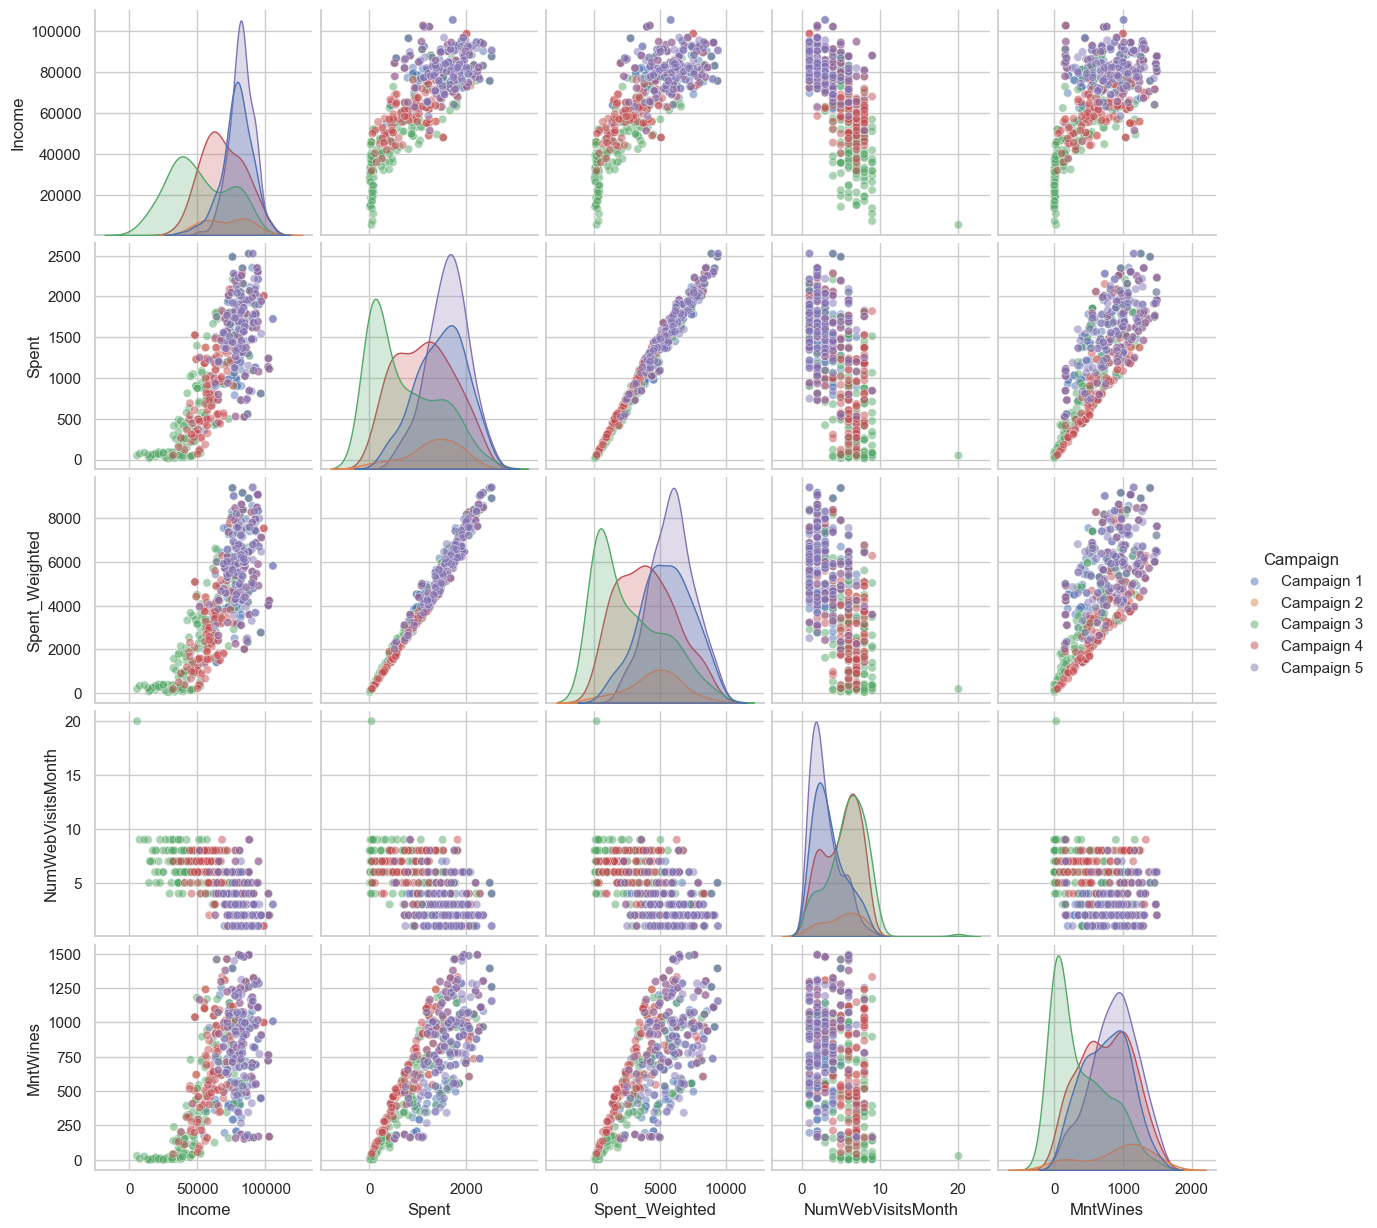

In [73]:
sns.set(style="whitegrid")

cols_to_plot = ["Income", "MntMeatProducts","MntWines", "Spent", "Age","NumWebVisitsMonth","NumStorePurchases" ]
cols_to_plot = ["Income", "MntMeatProducts","MntSweets", "Spent", "Age","NumWebVisitsMonth","NumStorePurchases" ]

cols_to_plot = anova_df["Feature"].iloc[:5]
sns.pairplot(
    df_campaign_all,
    vars=cols_to_plot,
    hue="Campaign",
    diag_kind="kde",
    plot_kws={"alpha": 0.5} 
)

plt.show()

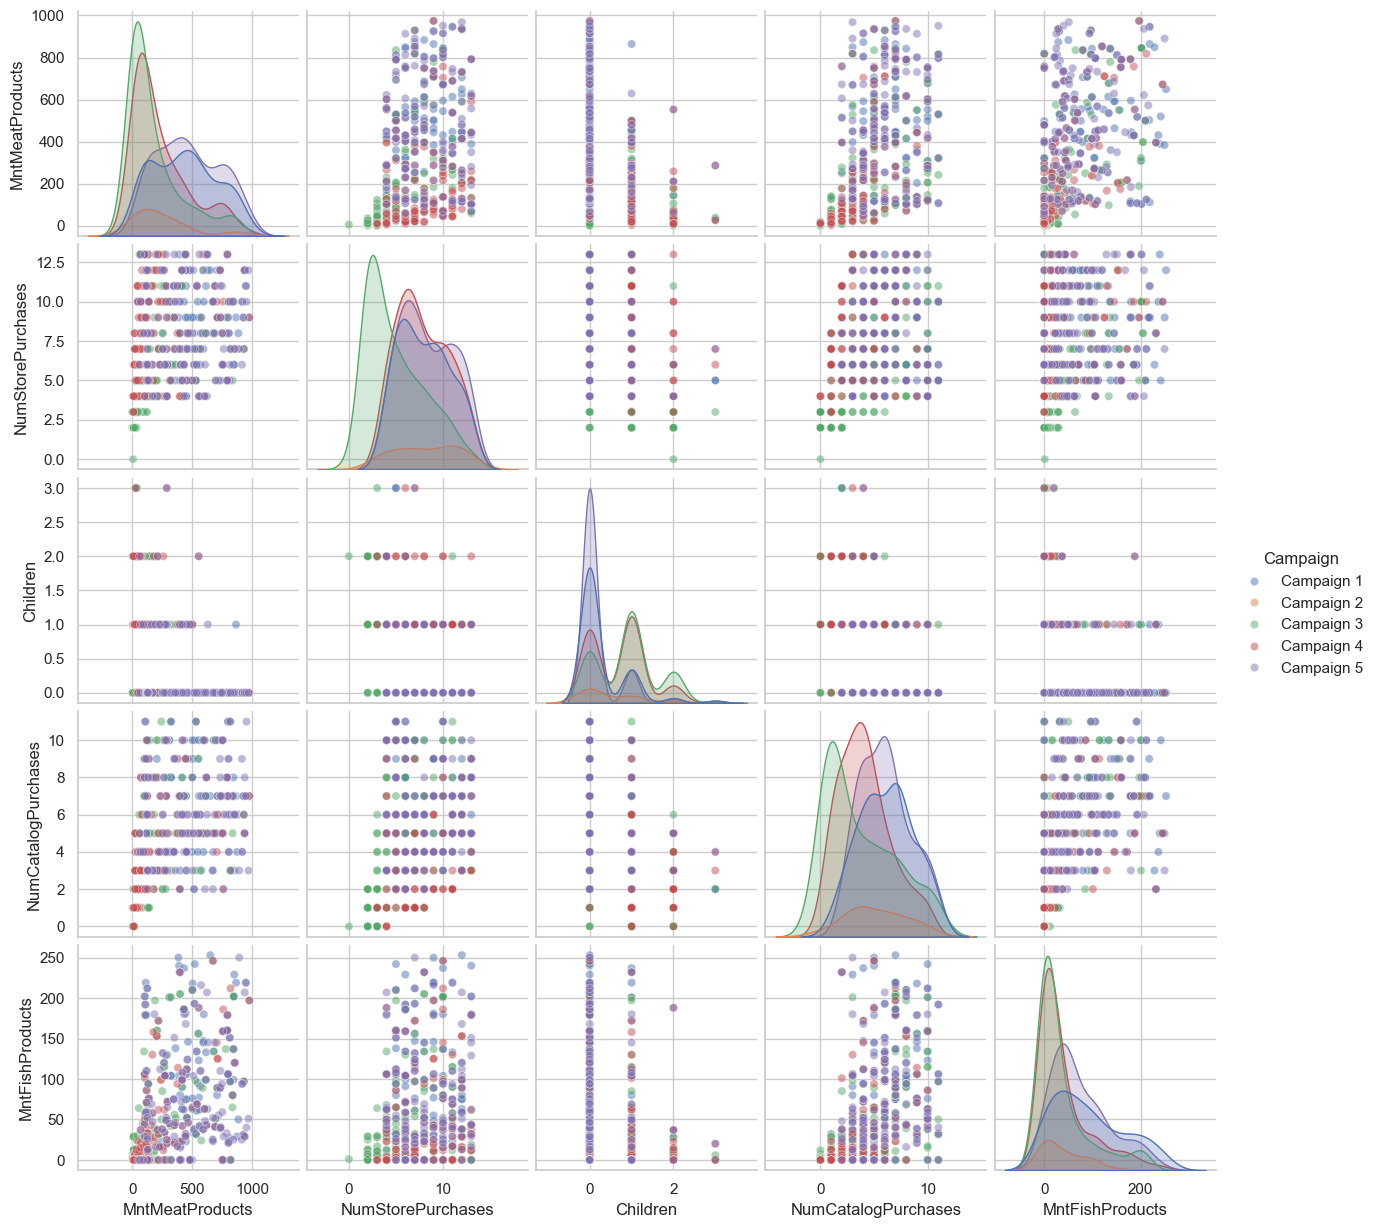

In [83]:
sns.set(style="whitegrid")

cols_to_plot = ["Income", "MntMeatProducts","MntWines", "Spent", "Age","NumWebVisitsMonth","NumStorePurchases" ]
cols_to_plot = anova_df["Feature"].iloc[5:10]
sns.pairplot(
    df_campaign_all,
    vars=cols_to_plot,
    hue="Campaign",
    diag_kind="kde",
    plot_kws={"alpha": 0.5} 
)

plt.show()

Boxplot Analysis
- Based on Income Boxplot, Campaign 5 and Campaign 1 targeted a lot of High Income Earners. Campaign 3 Targets a lot of lower income earners.
- Based on the MntMeatProd Boxplot, Campaign 5 and Campaign 1 saw the most meat sold. Campaign 3 saw the least.
- Based on the MntWines Boxplot, Campaign 3 sold the least amount of wine.
- Based on Amount Spent, Campaign 3 sold the lowest amount as well and campaign 5 sold the most amount and had the highest success in store purchases
- Campaign 3 had the most Website visits. May need to look into which campaign attracted the most parents vs non parents
- Campaign 1 and 5 had the lowest amount of people with kids
- Based on Age Boxplot, all campaigns targeted ages 40-50


In [75]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Columns to plot
# cols_to_plot = ["Income", "MntMeatProducts", "MntWines", "Spent", "Age", "NumWebVisitsMonth", "NumStorePurchases"]
cols_to_plot = anova_df["Feature"].iloc[:10]
# Grid layout (adjust columns per row)
n_cols = 3
n_rows = (len(cols_to_plot) + n_cols - 1) // n_cols

# Create subplots
fig = make_subplots(
    rows=n_rows, cols=n_cols,
    subplot_titles=cols_to_plot,
    horizontal_spacing=0.08,
    vertical_spacing=0.1
)

# Custom color palette
palette = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
campaigns = df_campaign_all["Campaign"].unique()

# Add one boxplot per feature per campaign
for i, feature in enumerate(cols_to_plot):
    row = i // n_cols + 1
    col = i % n_cols + 1
    
    for j, campaign in enumerate(campaigns):
        df_subset = df_campaign_all[df_campaign_all["Campaign"] == campaign]
        fig.add_trace(
            go.Box(
                y=df_subset[feature],
                name=campaign,
                boxmean='sd',        # shows mean and standard deviation
                marker_color=palette[j % len(palette)],
                line=dict(width=1),
                opacity=0.8
            ),
            row=row, col=col
        )
    
    # Set layout for each subplot
    fig.update_yaxes(title_text=feature, row=row, col=col)

# Layout and aesthetics
fig.update_layout(
    height=n_rows * 350,
    width=1200,
    title_text="Feature Distributions by Campaign",
    showlegend=False,
    template="plotly_white"
)

fig.show()


One-way ANOVA for each Marketing Campaign
- Which specific feature differ
- Univariate ANOVA
- Campaign 3 and 5 have then highest opposing difference among the marketing campaingns

In [76]:
df_main.columns

Index(['ID', 'Age', 'Education', 'Relationship Status', 'Income',
       'Days as Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Response', 'Spent', 'Spent_Weighted', 'Children',
       'Family_Size', 'Is_Parent'],
      dtype='object')

In [77]:
import itertools
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.weightstats import ttest_ind

features = ["Income", "Spent", "MntWines", "MntMeatProducts", "Age", "NumWebVisitsMonth", "NumStorePurchases"]
features = anova_df["Feature"].iloc[:10]

campaigns = df_campaign_all["Campaign"].unique()
pairs = list(itertools.combinations(campaigns, 2))

results = []

for feat in features:
    for g1, g2 in pairs:
        x1 = df_campaign_all.loc[df_campaign_all["Campaign"] == g1, feat].dropna()
        x2 = df_campaign_all.loc[df_campaign_all["Campaign"] == g2, feat].dropna()

        if len(x1) > 1 and len(x2) > 1:
            t_stat, p_val, df = ttest_ind(x1, x2, usevar='unequal')  # Welch t-test
            results.append({
                "Feature": feat,
                "Group1": g1,
                "Group2": g2,
                "t_stat": t_stat,
                "p_value": p_val
            })

ttest_df = pd.DataFrame(results)
ttest_df["Significant"] = ttest_df["p_value"] < 0.05
ttest_df.sort_values(["Feature", "p_value"], inplace=True)

print(ttest_df.head(5))

# Count how many times each campaign appears in a significant comparison
sig_counts = (
    pd.concat([
        ttest_df.loc[ttest_df["Significant"], "Group1"],
        ttest_df.loc[ttest_df["Significant"], "Group2"]
    ])
    .value_counts()
    .rename_axis("Campaign")
    .reset_index(name="Significant_Count")
)

print("\n=== Significant Difference Counts per Campaign ===")
print(sig_counts)


     Feature      Group1      Group2     t_stat       p_value  Significant
78  Children  Campaign 3  Campaign 5  10.677462  1.270000e-22         True
71  Children  Campaign 1  Campaign 3  -8.217557  6.133315e-15         True
79  Children  Campaign 4  Campaign 5   8.025093  2.532367e-14         True
72  Children  Campaign 1  Campaign 4  -5.803054  1.635542e-08         True
74  Children  Campaign 2  Campaign 3  -2.907903  5.847784e-03         True

=== Significant Difference Counts per Campaign ===
     Campaign  Significant_Count
0  Campaign 3                 35
1  Campaign 5                 32
2  Campaign 1                 29
3  Campaign 4                 25
4  Campaign 2                 19


## Modelling. Integrated Relationship Analysis

### Clustering. Unsupervised Learning

### Statistical Validation

### Conclusion